In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.ops as ops
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import FashionMNIST


from torchvision import models
import torch.nn.functional as F

from utils import CustomResNet, fashionmnist_dataloader, train_cutmix, val, criterion

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
train_loader, val_loader, test_loader= fashionmnist_dataloader(batch_size=50, basic_aug=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 16984192.42it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269031.58it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4970763.93it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9449574.18it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 17045446.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270574.53it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5090666.59it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12604948.62it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Combine the training and validation datasets into a single DataLoader
combined_loader = DataLoader(
    dataset=torch.utils.data.ConcatDataset([train_loader.dataset, val_loader.dataset]),
    batch_size=50,
    shuffle=True
)


In [ ]:
num_classes = 10
num_epochs = 10
alpha=2.5
criterion=criterion()

possible_layer_configurations = [
    [1, 3],       # Deform layers 1 and 3
]

for layers_to_deform in possible_layer_configurations:

    print(f"Training with deformable layers: {layers_to_deform}")
    model = CustomResNet(num_classes, layers_to_deform).to(device)
    optimizer = Adam(model.parameters(), lr=3e-4)
    print(model)

    current_patience = 0

    for epoch in range(1, num_epochs + 1):
        train_cutmix(model, criterion, combined_loader, optimizer, epoch, alpha, device)

    test_acc = val(model, criterion, test_loader, device)
    print(test_acc)

Training with deformable layers: [1, 3]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 


CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Identity()
      )
      (1): DeformConvBlock(
        (offset_conv): Conv2d(64, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (deform_conv): Conv2d(64, 64, kerne

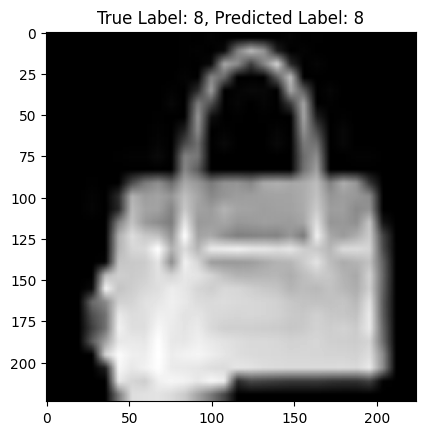

In [ ]:
import random
fashion_mnist = FashionMNIST(download=True, train=True, root=".").train_data.float()
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
test_dataset = FashionMNIST(root='./data', train=False, transform=transform, download=True)

random_index = random.randint(0, len(test_dataset) - 1)
data, label = test_dataset[random_index]
data=data.to(device)

output = model(data.unsqueeze(0))
pred = torch.max(output, 1)[1].item()

# Display the image
data = data.cpu().numpy()
plt.imshow(data[0], cmap='gray')
plt.title(f'True Label: {label}, Predicted Label: {pred}')
plt.show()